In [1]:
!pip install scanpy pyro-ppl --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import scanpy as sc

adata = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")

/tmp/ipython-input-2-1892814298.py:3: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")


  0%|          | 0.00/9.50M [00:00<?, ?B/s]

  0%|          | 0.00/26.9M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
print(adata.shape)
adata.obs.head()

(3798, 36601)


,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43


In [4]:
adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col'], dtype='object')

In [5]:
adata.obs["cancer_label"] = (
    (adata.obs["array_row"] < 35) & (adata.obs["array_col"] < 50)
).astype(int)

In [6]:
adata.obs["cancer_label"].value_counts()

,count
cancer_label,
0,3243
1,555


In [9]:
adata.X = adata.X.toarray()


In [10]:
adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)


In [14]:
adata.var["mean_expression"] = adata.X.mean(axis=0)
print("Has +inf:", np.isposinf(adata.var["mean_expression"]).any())
print("Has -inf:", np.isneginf(adata.var["mean_expression"]).any())
print("Has NaN:", np.isnan(adata.var["mean_expression"]).any())


Has +inf: False
Has -inf: False
Has NaN: False


In [15]:
# Step 1: compute variance for each gene
gene_variances = np.var(adata.X, axis=0)

# Step 2: get indices of top 1000 most variable genes
top_idx = np.argsort(gene_variances)[-1000:]

# Step 3: subset adata to those genes
adata = adata[:, top_idx]


In [16]:
adata.shape


(3798, 1000)

In [17]:
import torch

X = torch.tensor(adata.X, dtype=torch.float32)
y = torch.tensor(adata.obs["cancer_label"].values, dtype=torch.float32)


In [18]:
print(X.shape)
print(y.shape)
print(y[:5])

torch.Size([3798, 1000])
torch.Size([3798])
tensor([0., 0., 0., 0., 0.])


In [19]:
import pyro
import pyro.distributions as dist

def bayes_logistic_regression(X, y=None):
    n_features = X.shape[1]

    # Prior over weights and bias
    weights = pyro.sample("weights", dist.Normal(0., 1.).expand([n_features]).to_event(1))
    bias = pyro.sample("bias", dist.Normal(0., 1.))

    # Logistic regression
    logits = (X @ weights) + bias
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)


In [20]:
from pyro.infer import MCMC, NUTS

# Set up the NUTS sampler
nuts_kernel = NUTS(bayes_logistic_regression)

# MCMC config: 1000 posterior samples, 200 warmup steps
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X, y)

Sample: 100%|██████████| 1200/1200 [1:46:50,  5.34s/it, step size=1.86e-03, acc. prob=0.969]


In [21]:
posterior_samples = mcmc.get_samples()
weights_samples = posterior_samples["weights"]  # shape: (1000 samples, 1000 genes)
bias_samples = posterior_samples["bias"]

In [22]:
import matplotlib.pyplot as plt

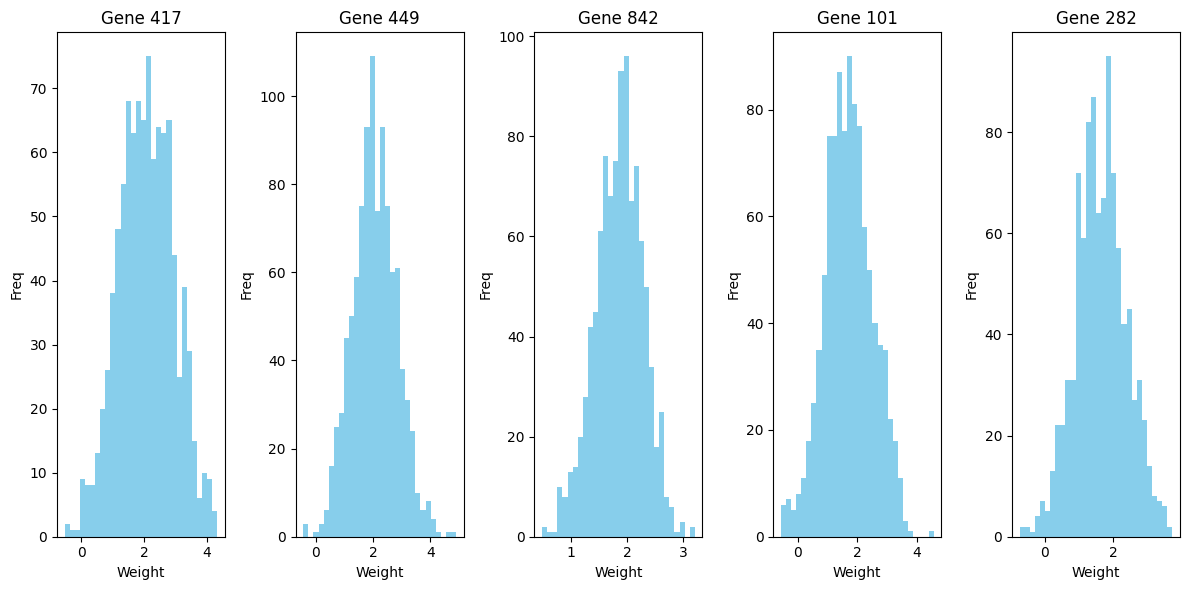

In [23]:
# Compute mean weight per gene
mean_weights = weights_samples.mean(dim=0)

# Get top 5 most positive weights (strongest cancer correlation)
top_gene_idxs = torch.topk(mean_weights, 5).indices

# Plot weight distribution for each
plt.figure(figsize=(12, 6))
for i, idx in enumerate(top_gene_idxs):
    plt.subplot(1, 5, i+1)
    plt.hist(weights_samples[:, idx].numpy(), bins=30, color="skyblue")
    plt.title(f"Gene {idx.item()}")
    plt.xlabel("Weight")
    plt.ylabel("Freq")
plt.tight_layout()
plt.show()

In [25]:
mean_preds.shape, std_preds.shape

((3798,), (3798,))

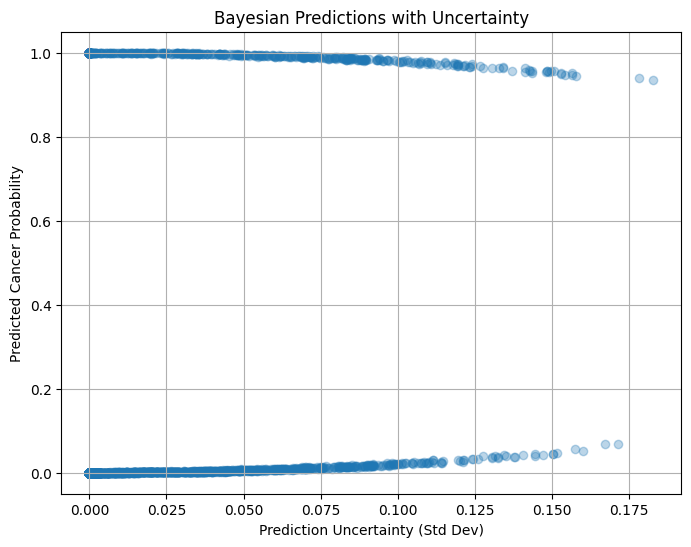

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(std_preds, mean_preds, alpha=0.3)
plt.xlabel("Prediction Uncertainty (Std Dev)")
plt.ylabel("Predicted Cancer Probability")
plt.title("Bayesian Predictions with Uncertainty")
plt.grid(True)
plt.show()

In [27]:
adata.obs["bayes_mean_pred"] = mean_preds
adata.obs["bayes_uncertainty"] = std_preds

/tmp/ipython-input-27-2020211882.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["bayes_mean_pred"] = mean_preds


/tmp/ipython-input-28-3199752619.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


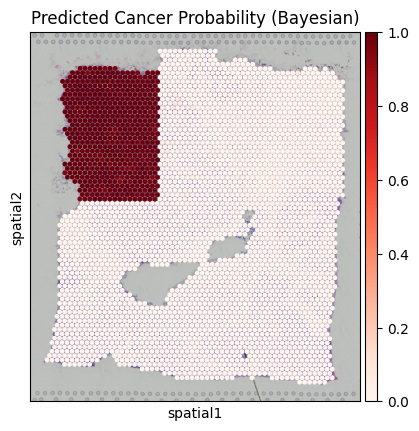

In [28]:
sc.pl.spatial(
    adata,
    color="bayes_mean_pred",
    cmap="Reds",
    size=1.5,
    title="Predicted Cancer Probability (Bayesian)",
)

In [29]:
import pandas as pd

# Get mean and std of each gene’s posterior weight
mean_w = weights_samples.mean(dim=0).numpy()
std_w = weights_samples.std(dim=0).numpy()

# Sort by highest mean weight (most predictive of cancer)
top_idx = mean_w.argsort()[::-1][:10]

# Build summary table
df = pd.DataFrame({
    "Gene Index": top_idx,
    "Mean Weight": mean_w[top_idx],
    "Weight Std Dev": std_w[top_idx]
})
df


,Gene Index,Mean Weight,Weight Std Dev
0,417,2.081050,0.866323
1,449,2.064561,0.769378
2,842,1.859442,0.425199
3,101,1.715101,0.796518
4,282,1.648351,0.740388
5,423,1.630859,0.754819
6,885,1.577283,0.508289
7,739,1.554889,0.703763
8,817,1.500638,0.644020
9,567,1.499600,0.669695
